In [40]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

### Extract pickle

In [92]:
import pickle
with open('vrp_20_e_500_A.pkl', 'rb') as f:
    x = pickle.load(f)

In [93]:
locations = x['problem'].locations # x,y for customers

In [94]:
solution = x['solution'] # list with next cutomers

In [95]:
capacities = x['problem'].capacities # cap for customers
capacities[0] = 0

In [96]:
distances = x['problem'].distance_matrix # matrix with distances

####  distance_matrix: An array of distances between locations on meters.
#### num_locations: The number of locations.
#### num_vehicles: The number of vehicles in the fleet.
#### depot: The index of the depot, the location where all vehicles start and end their routes.

In [45]:
original_list = locations

In [46]:
rounded_list = [[int((round(element*100, 2))) for element in row] for row in original_list]
rounded_list

[[69, 6],
 [66, 55],
 [8, 39],
 [49, 33],
 [34, 36],
 [85, 44],
 [31, 36],
 [45, 91],
 [46, 27],
 [91, 45],
 [54, 69],
 [83, 63],
 [64, 95],
 [57, 63],
 [3, 74],
 [85, 48],
 [23, 50],
 [13, 17],
 [10, 24],
 [66, 60],
 [66, 92]]

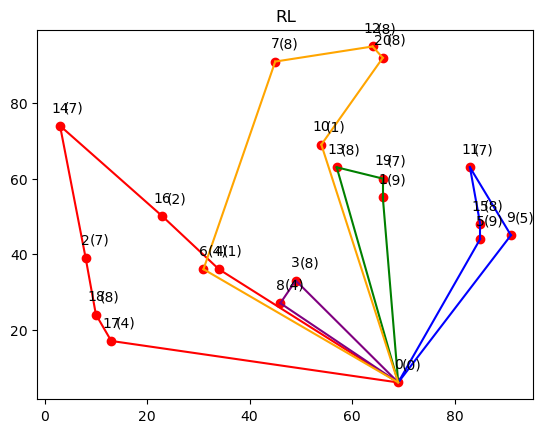

In [91]:
import matplotlib.pyplot as plt

points = rounded_list
routes = solution
data = capacities

x, y = zip(*points)

plt.scatter(x, y, color='red', marker='o')
route_colors = ['blue', 'green', 'red', 'purple', 'orange']

for index,route in enumerate(routes):
    color = route_colors[index % len(route_colors)] 

    for i in range(len(route) - 1):
        plt.plot([x[route[i]], x[route[i + 1]]], [y[route[i]], y[route[i + 1]]], color=color)

    plt.plot([x[route[-1]], x[route[0]]], [y[route[-1]], y[route[0]]], color='blue')

for i, txt in enumerate(range(len(x))):
    plt.annotate(txt, (x[i], y[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    
    
for i, txt in enumerate(data):
    plt.annotate(f"({txt})", (x[i], y[i]), textcoords="offset points", xytext=(10, 10), ha='center')

plt.title('RL')
plt.savefig('RL_20_500.png')
plt.show()


### start for paper

In [61]:
matrix = distances

In [62]:
len(matrix)

21

In [63]:
def float_to_int(z):
    for i, x in enumerate(z):
        for ii, y in enumerate(x):
            
            z[i][ii] = int(y *100)
    return z


In [64]:
matrix_dist = float_to_int(matrix)
matrix_dist

[[0,
  49,
  69,
  33,
  46,
  41,
  48,
  88,
  31,
  45,
  64,
  59,
  89,
  58,
  95,
  45,
  63,
  56,
  61,
  54,
  85],
 [49,
  0,
  60,
  28,
  37,
  21,
  40,
  41,
  35,
  26,
  17,
  18,
  39,
  12,
  65,
  20,
  43,
  65,
  64,
  4,
  36],
 [69,
  60,
  0,
  41,
  25,
  76,
  23,
  63,
  39,
  83,
  54,
  78,
  79,
  54,
  36,
  77,
  18,
  22,
  14,
  61,
  78],
 [33,
  28,
  41,
  0,
  15,
  37,
  18,
  58,
  6,
  43,
  36,
  45,
  64,
  31,
  62,
  39,
  31,
  39,
  40,
  31,
  61],
 [46,
  37,
  25,
  15,
  0,
  51,
  2,
  56,
  14,
  58,
  38,
  55,
  66,
  35,
  49,
  52,
  17,
  28,
  26,
  39,
  64],
 [41,
  21,
  76,
  37,
  51,
  0,
  54,
  61,
  42,
  6,
  39,
  18,
  54,
  33,
  86,
  3,
  62,
  76,
  77,
  24,
  50],
 [48,
  40,
  23,
  18,
  2,
  54,
  0,
  56,
  16,
  60,
  40,
  58,
  67,
  37,
  47,
  55,
  16,
  26,
  24,
  41,
  65],
 [88,
  41,
  63,
  58,
  56,
  61,
  56,
  0,
  64,
  65,
  24,
  47,
  20,
  30,
  44,
  59,
  46,
  80,
  75,
  37,
  21]

In [65]:
"""Capacited Vehicles Routing Problem (CVRP)."""
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] =  matrix_dist
    data["demands"] = capacities
    data["vehicle_capacities"] = [30, 30, 30, 30, 30, 30]
    data["num_vehicles"] = 6
    data["depot"] = 0
    return data

In [69]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    total_load = 0
    sol_all = []
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        sol_part = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} Load({route_load}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
            sol_part.append(node_index)
        sol_all.append(sol_part)
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")
    print(sol_all)


In [127]:
def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data["vehicle_capacities"],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
    )

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_parameters.time_limit.FromSeconds(2)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


In [128]:
main()

Objective: 736
Route for vehicle 0:
 0 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Route for vehicle 1:
 0 Load(0) ->  10 Load(1) ->  20 Load(9) ->  12 Load(17) ->  7 Load(25) ->  6 Load(29) ->  4 Load(30) ->  0 Load(30)
Distance of the route: 216m
Load of the route: 30

Route for vehicle 2:
 0 Load(0) ->  8 Load(4) ->  3 Load(12) ->  0 Load(12)
Distance of the route: 70m
Load of the route: 12

Route for vehicle 3:
 0 Load(0) ->  1 Load(9) ->  19 Load(16) ->  13 Load(24) ->  0 Load(24)
Distance of the route: 120m
Load of the route: 24

Route for vehicle 4:
 0 Load(0) ->  5 Load(9) ->  15 Load(17) ->  11 Load(24) ->  9 Load(29) ->  0 Load(29)
Distance of the route: 123m
Load of the route: 29

Route for vehicle 5:
 0 Load(0) ->  16 Load(2) ->  14 Load(9) ->  2 Load(16) ->  18 Load(24) ->  17 Load(28) ->  0 Load(28)
Distance of the route: 207m
Load of the route: 28

Total distance of all routes: 736m
Total load of all routes: 123
[[0], [0, 10, 20, 12, 7, 6, 4], [

In [ ]:
Dystans dla trasy 1: 124.8387441646666
Dystans dla trasy 2: 121.82804733188225
Dystans dla trasy 3: 210.3172052139899
Dystans dla trasy 4: 71.45362217011713
Dystans dla trasy 5: 218.89411033361765

### Distance for RL

In [126]:
import math

def calculate_distance(point1, point2):
    # Oblicz odległość euklidesową między dwoma punktami
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def calculate_total_distance(points, visited_points):
    total_distance = 0

    for i in range(len(visited_points) - 1):
        # Indeksy punktów, które chcemy porównać
        index1 = visited_points[i]
        index2 = visited_points[i + 1]

        # Pobierz współrzędne dla obu punktów
        point1 = points[index1]
        point2 = points[index2]

        # Oblicz odległość między punktami i dodaj do całkowitego dystansu
        distance = calculate_distance(point1, point2)
        total_distance += distance

    return total_distance

# Lista pozycji x i y
positions = [[69, 6], [66, 55], [8, 39], [49, 33], [34, 36], [85, 44], [31, 36], [45, 91],
              [46, 27], [91, 45], [54, 69], [83, 63], [64, 95], [57, 63], [3, 74], [85, 48],
              [23, 50], [13, 17], [10, 24], [66, 60], [66, 92]]

# Lista odwiedzanych punktów
visited_points_list = [[0, 9, 11, 15, 5, 0],
                       [0, 1, 19, 13, 0],
                       [0, 4, 16, 14, 2, 18, 17, 0],
                       [0, 3, 8, 0],
                       [0, 6, 7, 12, 20, 10, 0]]

# Oblicz całkowity dystans dla każdej trasy
all_dist = 0
for i, visited_points in enumerate(visited_points_list):
    total_distance = calculate_total_distance(positions, visited_points)
    print(f"Distance for route {i + 1}: {total_distance}")
    all_dist += total_distance
print(all_dist)

Distance for route 1: 124.8387441646666
Distance for route 2: 121.82804733188225
Distance for route 3: 210.3172052139899
Distance for route 4: 71.45362217011713
Distance for route 5: 218.89411033361765
747.3317292142735
